In [1]:
%pylab inline
import pandas as pd
from pyro.contrib.brm import brm
from pyro.contrib.brm.priors import PriorEdit, prior
from pyro.contrib.brm.fit import marginals, print_model, fitted, summary
from pyro.contrib.brm.family import getfamily, apply

Populating the interactive namespace from numpy and matplotlib


In this notebook we use brmp to model the Effron and Morris baseball dataset. The specific model used is taken from this [blog post](https://solomonkurz.netlify.com/post/stein-s-paradox-and-what-partial-pooling-can-do-for-you/). That post uses brms to define and fit the models it describes, and these are straight-forward to recreate in brmp. One of the two brms models described in the post is recreated below.

Similar models are implemented directly in Pyro [here](https://github.com/pyro-ppl/pyro/blob/dev/examples/baseball.py).

In [2]:
# Load the data.
# (Note that this dataset disagrees with the blog post on the row for player Williams.)
df = pd.read_csv('EfronMorrisBB.txt', sep='\t')
df['LastName'] = df['LastName'].astype('category')
df.rename(columns={'LastName': 'Player'}, inplace=True)
df.drop(['FirstName', 'RemainingAt-Bats', 'SeasonAt-Bats', 'SeasonHits', 'SeasonAverage'], axis=1, inplace=True)
df.head()

,Player,At-Bats,Hits,BattingAverage,RemainingAverage
0,Clemente,45,18,0.400,0.3460
1,Robinson,45,17,0.378,0.2981
2,Howard,45,16,0.356,0.2764
3,Johnstone,45,15,0.333,0.2218
4,Berry,45,14,0.311,0.2727


The model uses the binomial family as the response distribution, which requires us to give a value for its number of trials parameter. In brms this is achieved by writing something like `Hits | trials(...)` on the left hand side of the formula. brmp doesn't support this, but we can achieve the same thing by giving the number of trails when we specify the reponse distribution for the the model. (This only works for the simple case where the number of trials is the same for every row of the data frame.)

In [3]:
fit = brm(
    'Hits ~ 1 + (1 | Player)',
    df,
    # Response family:
    apply(getfamily('Binomial'), num_trials=45),
    # Priors:
    [
        PriorEdit(('b', 'intercept'), prior('Normal', [0., 1.5])),
        PriorEdit(('sd',),            prior('HalfNormal', [1.5]))
    ],
    iter=1000, warmup=1000)

Sample: 100%|██████████| 2000/2000 [01:30<00:00, 21.99it/s, step size=3.32e-01, acc. rate=0.965]


The following model summary matches the blog post closely. (Compare with the table that appears immediately after the `fit_z$fit` command in the post.)

In [4]:
marginals(fit)

                                mean    sd  2.5%   25%   50%   75% 97.5%
                   b_intercept -1.02  0.09 -1.19 -1.08 -1.02 -0.96 -0.85
          sd_Player__intercept  0.16  0.11  0.01  0.07  0.14  0.23  0.40
  r_Player[Alvarado,intercept] -0.00  0.16 -0.34 -0.07 -0.00  0.07  0.36
     r_Player[Alvis,intercept] -0.11  0.18 -0.63 -0.18 -0.06  0.00  0.15
     r_Player[Berry,intercept]  0.04  0.16 -0.24 -0.04  0.02  0.11  0.43
r_Player[Campaneris,intercept] -0.07  0.16 -0.47 -0.14 -0.03  0.02  0.21
  r_Player[Clemente,intercept]  0.13  0.18 -0.15  0.00  0.08  0.22  0.59
    r_Player[Howard,intercept]  0.08  0.16 -0.19 -0.01  0.04  0.17  0.48
 r_Player[Johnstone,intercept]  0.07  0.16 -0.22 -0.02  0.04  0.14  0.44
 r_Player[Kessinger,intercept]  0.01  0.16 -0.32 -0.06  0.00  0.08  0.39
    r_Player[Munson,intercept] -0.10  0.18 -0.55 -0.17 -0.05  0.01  0.18
r_Player[Petrocelli,intercept] -0.05  0.16 -0.43 -0.11 -0.02  0.03  0.24
  r_Player[Robinson,intercept]  0.10  0.17 -0.14 -0

Here we recreate the plot of model predictions vs. the true remaining batting average. (Compare with the right-most plot in [this image](https://solomonkurz.netlify.com/post/2019-02-23-stein-s-paradox-and-what-partial-pooling-can-do-for-you_files/figure-html/unnamed-chunk-24-1.png).) This appears similar to the plot in the blog post. (Though note that we have different data for player Williams, as mentioned earlier.) This makes use of the `fitted` function which is analogous to the [`fitted`](https://rdrr.io/cran/brms/man/fitted.brmsfit.html) method in brms.

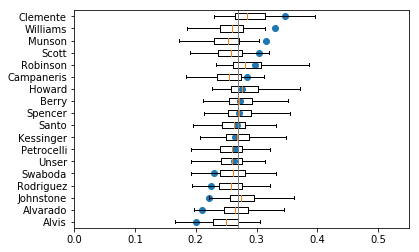

In [5]:
sampled_probs = fitted(fit, 'response')
tups = sorted(zip(df['RemainingAverage'], df['Player'], sampled_probs.T))
avg, labels, samples = zip(*tups)
xlim((0.0, 0.55))
boxplot(samples, vert=False, labels=labels, showfliers=False, whis=[2.5,97.5])
scatter(avg, range(1, len(df)+1));
axvline(numpy.array(avg).mean(), c='gray', lw=1);

## Appendix

In [6]:
print_model(fit)

Population
----------------------------------------
Coef Priors:
intercept       | Normal(mu=0.0, sigma=1.5)
Group 0
----------------------------------------
Factor: Player
Levels: ['Alvarado', 'Alvis', 'Berry', 'Campaneris', 'Clemente', 'Howard', 'Johnstone', 'Kessinger', 'Munson', 'Petrocelli', 'Robinson', 'Rodriguez', 'Santo', 'Scott', 'Spencer', 'Swaboda', 'Unser', 'Williams']
Corr. Prior: None
S.D. Priors:
intercept       | HalfNormal(sigma=1.5)
Response
----------------------------------------
Family: Binomial(num_trials=45)
Link:
  Parameter: probs
  Function:  logit
Priors:


In [7]:
print(fit.model.code)

def model(X, Z_0, J_0, y_obs=None):
    assert type(X) == torch.Tensor
    N = X.shape[0]
    M = 1
    assert X.shape == (N, M)
    b_0 = pyro.sample("b_0", dist.Normal(torch.tensor(0.0).expand([1]), torch.tensor(1.5).expand([1])).to_event(1))
    b = torch.cat([b_0])
    assert b.shape == (M,)
    mu = torch.mv(X, b)
    
    # [0] Categorical(name='Player', levels=['Alvarado', 'Alvis', 'Berry', 'Campaneris', 'Clemente', 'Howard', 'Johnstone', 'Kessinger', 'Munson', 'Petrocelli', 'Robinson', 'Rodriguez', 'Santo', 'Scott', 'Spencer', 'Swaboda', 'Unser', 'Williams'])
    M_0 = 1 # Number of coeffs
    N_0 = 18 # Number of levels
    assert type(Z_0) == torch.Tensor
    assert Z_0.shape == (N, M_0) # N x 1
    assert type(J_0) == torch.Tensor
    assert J_0.shape == (N,)
    sd_0_0 = pyro.sample("sd_0_0", dist.HalfNormal(torch.tensor(1.5).expand([1])).to_event(1))
    sd_0 = torch.cat([sd_0_0])
    assert sd_0.shape == (M_0,) # 1
    z_0 = pyro.sample("z_0", dist.Normal(torch.tensor(0.0